# 15. Model extensions

## Numerical experiments - Week 18/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Despite the moderate success of the analytical model in explaining the phase transition of the spore inoculum from a germinated to an ungerminated state when the critical threshold of $10^5$ spores/mL is crossed, a few issues remain to be addressed:

- It is known that spore cultures reach an asymptotic limit of their germination fraction, but the new analytical model has not yet been shown to represent that.
- The estimated effective permeation constant $P_{\textrm{eff}}$ is too low for any realistic barrier which does not interact with the inhibitor.
- The model cannot represent density-driven inhibition and exogenously driven exhibition in parallel.

The following model extensions are an attempt to address these issues.

## Prerequisite libraries

In [45]:
using PyPlot
using DataFrames
using CSV
using BlackBoxOptim
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. Replicating Dantigny-like behaviour

### 1.1. Implementation of the Dantigny model

The model developed by Dantigny et al. [1] describes the germination percentage of a fungal culture through the formula

$$
\begin{equation}
p=p_{\textrm{max}}\left[1-\frac{1}{1+\left(\frac{t}{\tau_g}\right)^\nu}\right].
\end{equation}
$$

In it, $t$ is the time of evaluation of the probability, $p_{\textrm{max}}$ is a saturation limit of the germination fraction, $\tau_g$ is a characteristic germination time denoting the inflection point where $p=p_{\textrm{max}}/2$ and $\nu$ is a design parameter representing the heterogeneity of the culture.

It has been shown that the value of $p$ in this model saturates to $p_{\textrm{max}}$ in the long-time limits and has an asymmetrical sigmoid shape for $\nu>1$. As an illustration, some inferred parameters from Ijadpanahsaravi et al. [2] which describe the germination rate of _A. niger_ conidia in an alanine-rich environment, at a density of $1.333\times 10^5$ spores/mL, are $p_{\textrm{max}}=84.14$, $\tau_g=5.77$ and $\nu=3.36$. The code below illustrates the evolution of the germination percentage over the course of 50 hours.

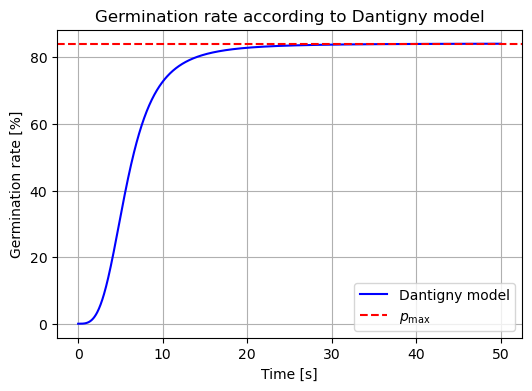

In [35]:
function dantigny(t, p_max, τ, ν)
    """
    Dantigny model for the germination of a fungal culture.
    inputs:
        t: time (in hours)
        p_max: maximum germination rate
        τ: time constant (in hours)
        ν: design parameter (dimensionless)
    outputs:
        p: germination rate (dimensionless)
    """
    p = p_max * (1 - 1 / (1 + (t / τ)^ν))
    return p
end

t_max = 50 # hours
p_max = 84.14
τ = 5.77
ν = 3.36

times = LinRange(0, t_max, 1000)
ps = dantigny.(times, p_max, τ, ν)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, ps, label="Dantigny model", color="blue")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Germination rate [%]")
ax.grid()
ax.set_title("Germination rate according to Dantigny model")

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.legend()

gcf()

### 1.2. Time-dependent germination probability

Next, the time-dependent germination probability is simulated using the volume-based analytical model. Knowing that the germination response saturates at around 24 hours, the parameters of the model can be fitted again for the time-dependent comparison.

In [43]:
df_germination = DataFrame(CSV.File("Data/swelling_germination_results.csv"; header=true))

# ===== Filter data from germination with many densities =====

# Filter the data to only include swelling
df_germination_swelling = filter(row -> row[1] == "Swelling", df_germination)

# Expression for parsing
regex_triplet = r"(-?\d+\.\d+)\[(-?\d+\.\d+);(-?\d+\.\d+)\]*.*"

# Function to parse a string and return three numbers
function parse_numbers(s)
    m = match(regex_triplet, s)
    if m !== nothing
        num1 = parse(Float64, m.captures[1])
        num2 = parse(Float64, m.captures[2])
        num3 = parse(Float64, m.captures[3])
        return num1, num2, num3
    else
        return missing, missing, missing
    end
end

# Parse Pmax and its confidence intervals
Pmax_parsed = [parse_numbers(row[1]) for row in eachrow(df_germination_swelling[!, 4])]
Pmax_vals = [x[1] for x in Pmax_parsed]
PmaxCIlow_vals = [x[2] for x in Pmax_parsed]
PmaxCIhigh_vals = [x[3] for x in Pmax_parsed]

# Parse tau and its confidence intervals
tau_parsed = [parse_numbers(row[1]) for row in eachrow(df_germination_swelling[!, 5])]
tau_vals = [x[1] for x in tau_parsed]
tauCIlow_vals = [x[2] for x in tau_parsed]
tauCIhigh_vals = [x[3] for x in tau_parsed]

# Reconstruct the DataFrame with the parsed values
df_germination_rebuilt = DataFrame(
    :CarbonSource => df_germination_swelling[!, 2],
    :Density => inverse_uL_to_mL(df_germination_swelling[!, 3] / 150),
    :Pmax => Pmax_vals,
    :Pmax_CI_Lower => PmaxCIlow_vals,
    :Pmax_CI_Upper => PmaxCIhigh_vals,
    :tau => tau_vals,
    :tau_CI_Lower => tauCIlow_vals,
    :tau_CI_Upper => tauCIhigh_vals,
    :N => df_germination_swelling[!, 8],
    :M => df_germination_swelling[!, 9]
)

df_germination_rebuilt

Row,CarbonSource,Density,Pmax,Pmax_CI_Lower,Pmax_CI_Upper,tau,tau_CI_Lower,tau_CI_Upper,N,M
,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,Ala,33333.3,95.98,92.44,99.51,6.93,6.59,7.26,373,10
2,Ala,66666.7,90.81,86.43,95.18,5.28,4.84,5.72,979,37
3,Ala,1.33333e5,84.14,78.58,89.69,5.77,5.17,6.37,1112,66
4,Ala,2.66667e5,71.91,61.67,82.14,6.31,5.06,7.57,1301,89
5,Arg,33333.3,25.06,-0.83,50.96,15.0,1.47,28.53,626,94
6,Arg,66666.7,16.61,5.63,27.6,15.0,7.02,22.98,1026,19
7,Arg,1.33333e5,13.69,4.32,23.05,15.0,-0.44,30.44,1372,14
8,Arg,2.66667e5,11.25,-1.93,24.43,15.0,-12.95,42.95,1408,105
9,Pro,33333.3,94.95,91.22,98.69,4.55,4.19,4.91,526,7


5.99183041318138e-6
Carbon source: Ala
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.57 secs, 12 evals, 6 steps, improv/step: 0.833 (last = 0.8333), fitness=0.114120234
1.08 secs, 23 evals, 12 steps, improv/step: 0.667 (last = 0.5000), fitness=0.033554110
1.60 secs, 35 evals, 19 steps, improv/step: 0.737 (last = 0.8571), fitness=0.033554110
2.12 secs, 47 evals, 25 steps, improv/step: 0.760 (last = 0.8333), fitness=0.033554110
2.65 secs, 60 evals, 32 steps, improv/step: 0.781 (last = 0.8571), fitness=0.033554110
3.19 secs, 73 evals, 40 steps, improv/step: 0.750 (last = 0.6250), fitness=0.033554110
3.72 secs, 86 evals, 50 steps, improv/step: 0.700 (last = 0.5000), fitness=0.033554110
4.26 secs, 99 evals, 60 steps, improv/step: 0.700 (last = 0.7000), fitness=0.033554110
4.79 secs, 113 evals, 70 steps, improv/step: 0.686 (last = 0.6

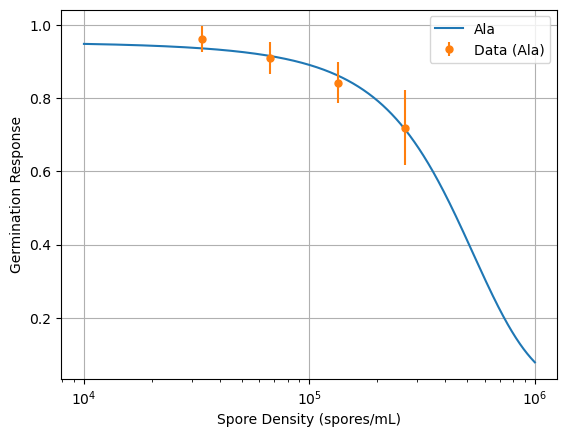

In [46]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3
c_ex = 0.0
μ_ψ = 1.0
σ_ψ = 1.0
t_max = 24

# Model wrapper
wrapper(ρ_exp, params) = germination_response(10 .^ ρ_exp, c_ex, 10 .^ (-params[1]), μ_ψ, σ_ψ, params[2], params[3], μ_ξ, σ_ξ, t_max .* 3600)

println(wrapper(5, [3, 1e-6, 1e-8]))

# Initial guesses and bounds for the parameters
p0 = [3, 1e-6, 1e-8] # Initial guess for Pₛ, μ_γ, σ_γ
lower_bounds = [2, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
sample_density_exp = LinRange(4, 6, 1000)

src = "Ala"

# Gather data
println("Carbon source: ", src)
df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
spore_densities = df_src[!, :Density]
spore_density_exponents = log10.(spore_densities)
germination_responses = df_src[!, :Pmax] * 0.01

# confidence_intervals
err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
err_lo[err_lo .< 0] .= 0
err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
err_lo = err_lo * 0.01
err_hi = err_hi * 0.01

# Define a scalar objective: sum of squared errors
function obj(params)
    ŷ = wrapper.(spore_density_exponents, Ref(params))
    return sum(abs2, ŷ .- germination_responses)
end

# Fit model
res = bboptimize(params -> obj(params);
                SearchRange = bounds,
                NumDimensions = 3,
                MaxSteps = 100000)
p_opt = best_candidate(res)

Pₛ_fit = 10 .^ (-p_opt[1])
μ_γ_fit = p_opt[2]
σ_γ_fit = p_opt[3]

println("Optimized parameters:")
println("Pₛ: ", Pₛ_fit)
println("μ_γ: ", μ_γ_fit)
println("σ_γ: ", σ_γ_fit)
println("")

fit_responses = [wrapper(exponent, p_opt) for exponent in sample_density_exp]
ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

In [51]:
ρ = 1.33333e5 # spores/mL
# Pₛ = 3.176160310369686e-4 # um/s
# μ_γ = 3.779776915258249e-5
# σ_γ = 1.818526243554919e-5

times = LinRange(0, t_max * 2, 1000) # hours

# A, V = compute_spore_area_and_volume_from_dia(2 * μ_γ)
# Pₛ = V / (τ * A)
# println(Pₛ)

p_evolution = germination_response.(ρ, c_ex, Pₛ_fit, μ_ψ, σ_ψ, μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, times .* 3600) .* 100 # Convert to percentage

1000-element Vector{Float64}:
  0.0
  1.0985270640168942e-17
  2.4363903065991703e-17
  4.065088529436483e-17
  6.047054331408462e-17
  8.457942433987633e-17
  1.1389389645976916e-16
  1.495234209807435e-16
  1.9281064432034925e-16
  2.4537968409713046e-16
  ⋮
 92.72379738470545
 92.72379991816221
 92.72380239888359
 92.72380482797399
 92.7238072065146
 92.7238095355638
 92.72381181615765
 92.72381404931043
 92.72381623601504

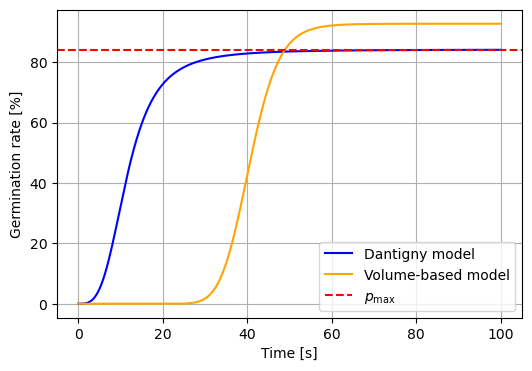

In [52]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, ps, label="Dantigny model", color="blue")
ax.plot(times, p_evolution, label="Volume-based model", color="orange")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Germination rate [%]")
ax.grid()
# ax.set_title("Germination rate according to Dantigny model")

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.legend()

gcf()

Despite the common sigmoidal shape of the resulting evolutions, two major differences can be observed in the two models. First, the Dantigny saturates to levels lower than a full germination, while the volume-based model always saturates to 100%. Second, the peak of germination (concurrent with the steepest slope of the curve) may occur at a different time in the volume-based model, since the models rely on the attainment of a germination level at a specific time. This is also a consequence of the fact that the targeted germination level is not an asymptotic limit, but a momentary snapshot.

## 2. Cell wall adsorption model

## 3. Inducer permeation model

## 4. Permeation modulation model

## References

- [1] Dantigny, P., Nanguy, S.P., Judet-Correia, D., & Bensoussan, M. (2011). A new model for germination of fungi. International journal of food microbiology, 146 2, 176-81 .
- [2] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .